# Image Segmentaion using Classic Methods

## Part 1: Contour Approach

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

FIGSIZE = (15, 15)

### Load and display `pout.tif` image

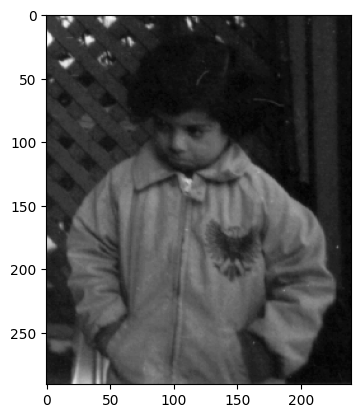

In [2]:
pout = cv2.imread("images/pout.tif", cv2.COLOR_BGR2GRAY)
pout.shape

plt.imshow(pout, cmap='gray')

### Detecting Edges using Sobel

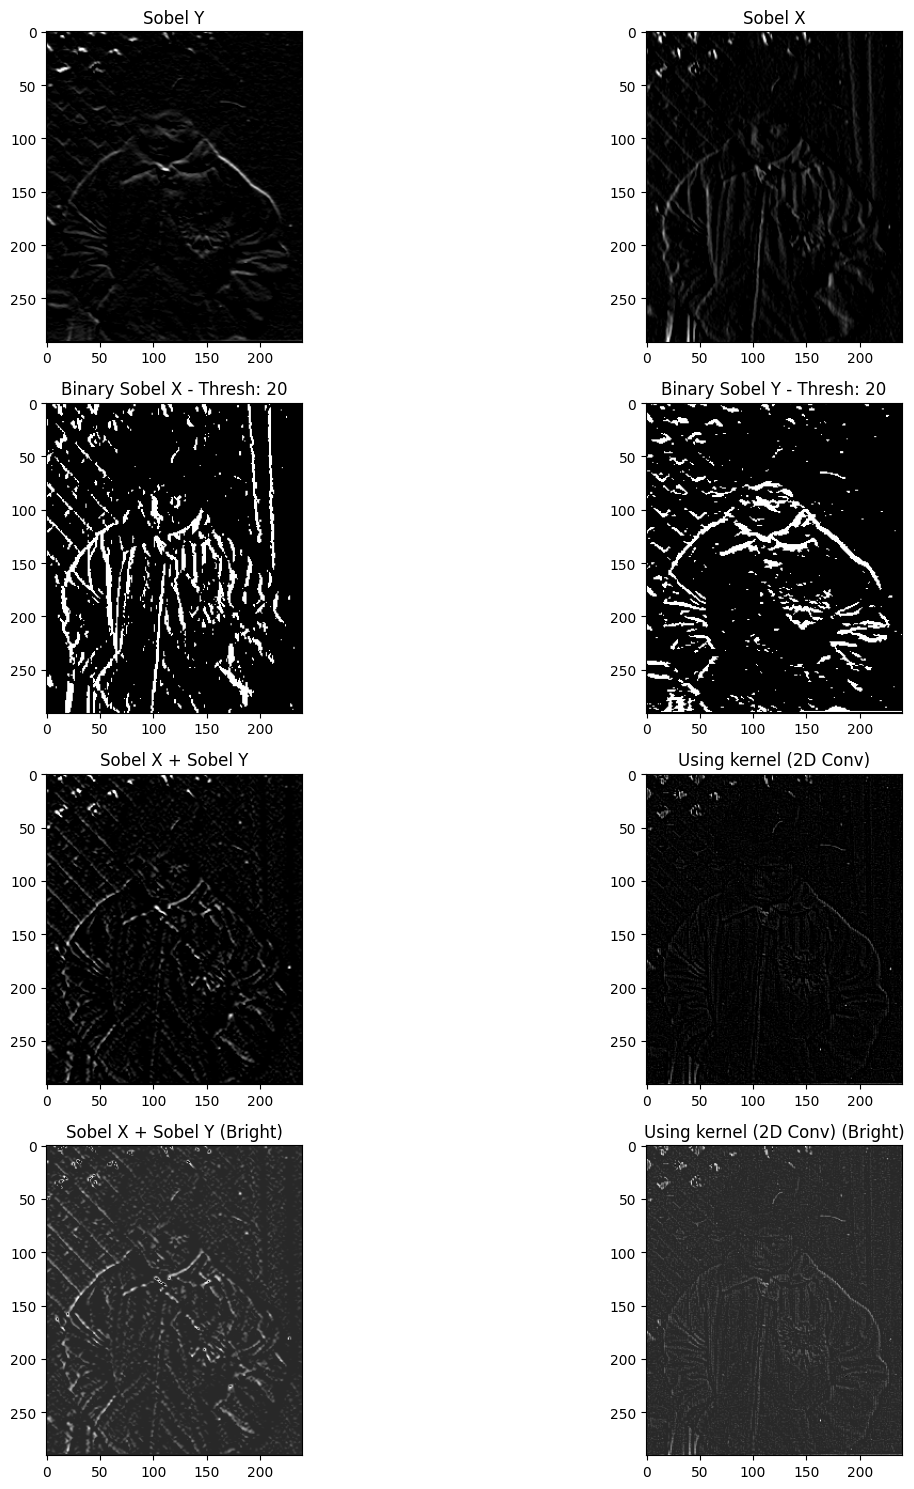

===== THRESHOLDING AFTER SOBEL =====


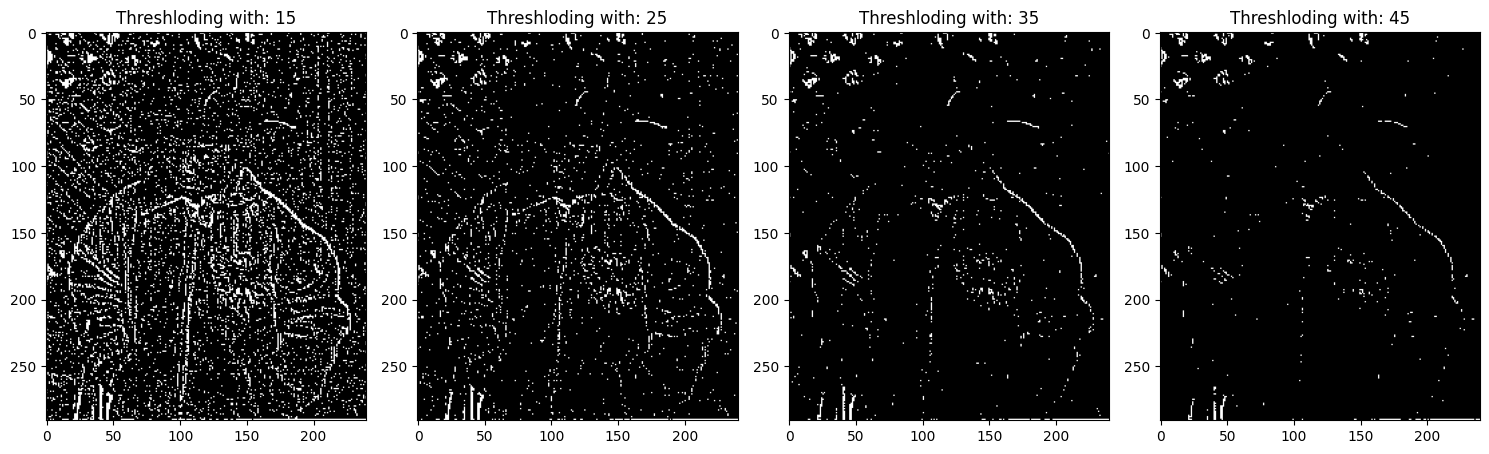

In [37]:
# 3x3 Y-direction  kernel
sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
# 3 X 3 X-direction kernel
sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])

# Filter the image using filter2D, which has inputs: (grayscale image, bit-depth, kernel)
filtered_image_y = cv2.filter2D(pout, -1, sobel_y)
filtered_image_x = cv2.filter2D(pout, -1, sobel_x)

# Convolution: sobel-X + sobel-Y (Gradient of the image)
filterd_x_y = cv2.filter2D(filtered_image_x, -1, sobel_y)
filtered_image_y_hist = cv2.calcHist([filtered_image_y], [0], None, [256], [0, 256]) 
# Using the kernel (2D Convolution Matrix)
kernel2 = np.array([[-1, -1, -1],
                    [-1, 8, -1],
                    [-1, -1, -1]])
convolution_image = cv2.filter2D(pout, -1, kernel2)

threshold = 20
(_, binary_sobel_y) = cv2.threshold(filtered_image_y, threshold, 255, cv2.THRESH_BINARY)
(_, binxry_sobel_x) = cv2.threshold(filtered_image_x, threshold, 255, cv2.THRESH_BINARY)


# Increase Brightness
const = 40
bright_xy = filterd_x_y + const
bright_conv = convolution_image + const

## DISPLAY ##
_, plots = plt.subplots(nrows=4, ncols=2, figsize=FIGSIZE)
plots[0][0].imshow(filtered_image_y, cmap='gray')
plots[0][0].set_title("Sobel Y")
plots[0][1].imshow(filtered_image_x, cmap='gray')
plots[0][1].set_title("Sobel X")
plots[1][0].imshow(binxry_sobel_x, cmap='gray')
plots[1][0].set_title(f"Binary Sobel X - Thresh: {threshold}")
plots[1][1].imshow(binary_sobel_y, cmap='gray')
plots[1][1].set_title(f"Binary Sobel Y - Thresh: {threshold}")
plots[2][0].imshow(filterd_x_y, cmap='gray')
plots[2][0].set_title(f"Sobel X + Sobel Y")
plots[2][1].imshow(convolution_image, cmap='gray')
plots[2][1].set_title(f"Using kernel (2D Conv)")
plots[3][0].imshow(bright_xy, cmap='gray')
plots[3][0].set_title(f"Sobel X + Sobel Y (Bright)")
plots[3][1].imshow(bright_conv, cmap='gray')
plots[3][1].set_title(f"Using kernel (2D Conv) (Bright)")
plt.tight_layout()
plt.show()

print("===== THRESHOLDING AFTER SOBEL =====")

_, plots = plt.subplots(nrows=1, ncols=4, figsize=FIGSIZE)
for i, thresh in zip(range(4), (15, 25, 35, 45)):
  (_, binary_convolution_img) = cv2.threshold(convolution_image, thresh, 255, cv2.THRESH_BINARY)
  plots[i].set_title(f"Threshloding with: {thresh}")
  plots[i].imshow(binary_convolution_img, cmap='gray')

plt.tight_layout()
plt.show()


### Region-Based Segmentation

#### Segment Image using Threshloding

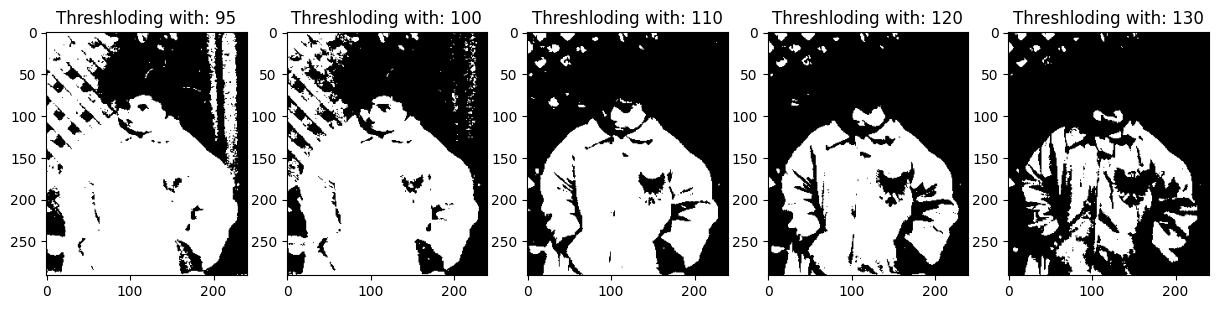

In [4]:
pout = cv2.imread("images/pout.tif", cv2.COLOR_BGR2GRAY)

_, plots = plt.subplots(nrows=1, ncols=5, figsize=FIGSIZE)
for i, thresh in zip(range(5), (95, 100, 110, 120, 130)):
  (_, binary_img) = cv2.threshold(pout, thresh, 255, cv2.THRESH_BINARY)
  plots[i].set_title(f"Threshloding with: {thresh}")
  plots[i].imshow(binary_img, cmap='gray')

plt.show()

### Segment Image using Split-Merge
[ref](https://medium.com/@dillihangrae/region-splitting-and-merging-170abd69a10a)

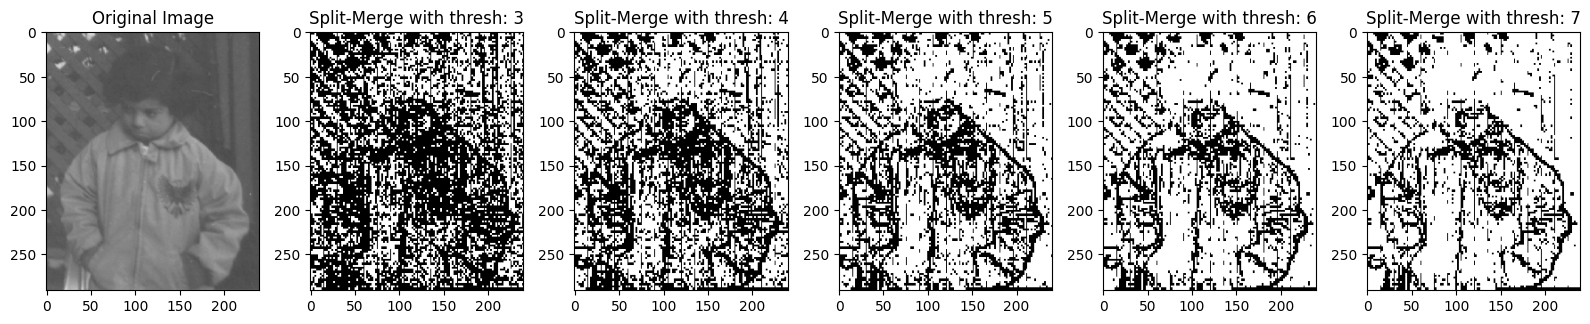

In [24]:
pout = cv2.imread("images/pout.tif")

def is_homogeneous(region, threshold):
  min_val, max_val = np.min(region), np.max(region)
  return (max_val - min_val) <= threshold

def split_and_merge(image, threshold):
  
  def recursive_split(region):
    rows, cols = region.shape
    if rows <= 1 or cols <= 1:
      return np.zeros_like(region, dtype=np.uint8)

    if is_homogeneous(region, threshold):
      return np.ones_like(region, dtype=np.uint8)
    
    # Split the region into four quadrants
    mid_row, mid_col = rows // 2, cols // 2
    
    top_left = region[:mid_row, :mid_col]
    top_right = region[:mid_row, mid_col:]
    bottom_left = region[mid_row:, :mid_col]
    bottom_right = region[mid_row:, mid_col:]
    
    # Create empty segmented image of the same size
    segmented_quadrants = np.zeros_like(region, dtype=np.uint8)
    
    # Recursive splitting and assignment to segmented_quadrants
    segmented_quadrants[:mid_row, :mid_col] = recursive_split(top_left)
    segmented_quadrants[:mid_row, mid_col:] = recursive_split(top_right)
    segmented_quadrants[mid_row:, :mid_col] = recursive_split(bottom_left)
    segmented_quadrants[mid_row:, mid_col:] = recursive_split(bottom_right)
    
    return segmented_quadrants
  
  def merge_regions(segmented):
    """Merge adjacent regions if they are similar."""
    # Placeholder function for merging adjacent regions if needed
    # TODO: COMPLETE
    return segmented
  
  # Ensure the image is grayscale
  if len(image.shape) == 3:
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
  # Apply the region splitting and merging algorithm
  segmented_image = recursive_split(image)
  segmented_image = merge_regions(segmented_image)
  
  return segmented_image


## DISPLAYING RESULTS ##
_, plots = plt.subplots(nrows=1, ncols=6, figsize=(16, 16))
plots[0].set_title("Original Image")
plots[0].imshow(pout)
for i, thresh in zip(range(1, 6), (3, 4, 5, 6, 7)):
  segmeted_image = split_and_merge(pout, thresh)
  plots[i].set_title(f"Split-Merge with thresh: {thresh}")
  plots[i].imshow(segmeted_image, cmap='gray')
plt.tight_layout()
plt.show()

## Lung Segmentation

(512, 512)

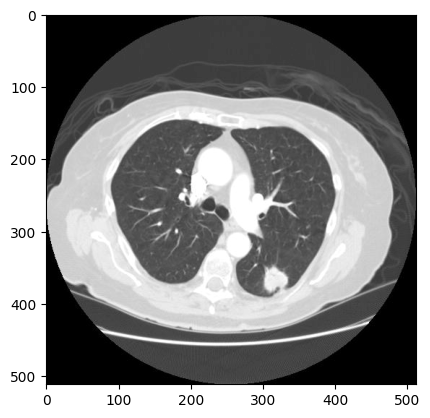

In [29]:
lung = cv2.imread("images/CT001 (1).jpg")
lung = cv2.cvtColor(lung, cv2.COLOR_BGR2GRAY)
plt.imshow(lung, cmap='gray')

### Segement using Sobel

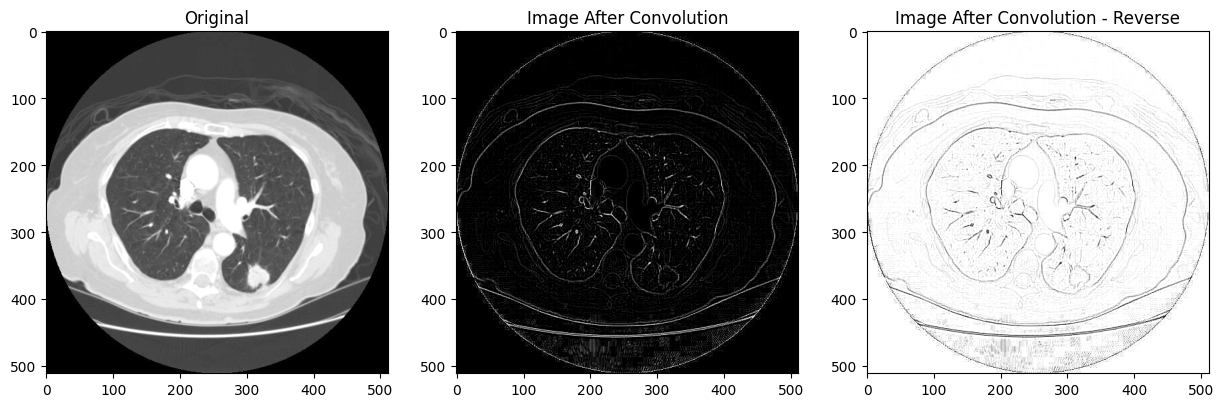

In [45]:
# Using the kernel (2D Convolution Matrix)
kernel2 = np.array([[-1, -1, -1],
                    [-1, 8, -1],
                    [-1, -1, -1]])
convolution_image = cv2.filter2D(lung, -1, kernel2)
inverse_conv = 255 - convolution_image


_, plots = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))
plots[0].set_title("Original")
plots[0].imshow(lung, cmap='gray')
plots[1].set_title("Image After Convolution")
plots[1].imshow(convolution_image, cmap='gray')
plots[2].set_title("Image After Convolution - Reverse")
plots[2].imshow(inverse_conv, cmap='gray')
plt.show()

### Segment using Thresholding - Otsu

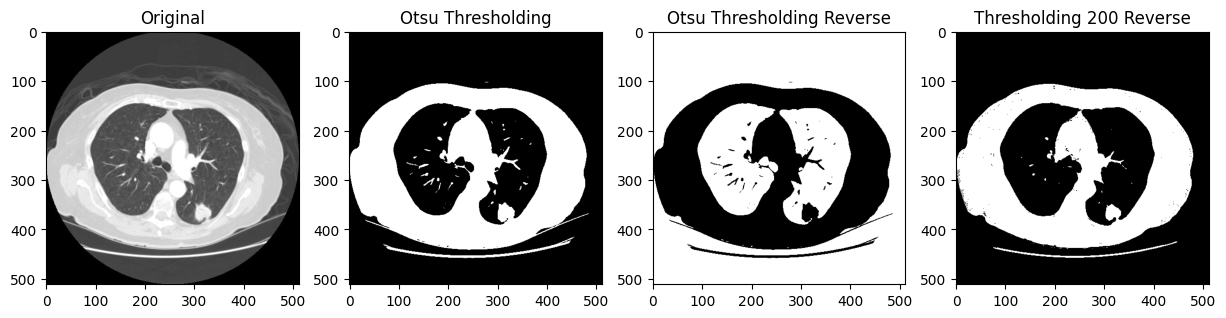

In [72]:
(_, im_bw_otsu) = cv2.threshold(lung, 10, 255, cv2.THRESH_OTSU)
thresh = 200
(_, im_bw_thresh) = cv2.threshold(lung, thresh, 255, cv2.THRESH_BINARY)

_, plots = plt.subplots(nrows=1, ncols=4, figsize=(15, 15))
plots[0].set_title("Original")
plots[0].imshow(lung, cmap='gray')
plots[1].set_title("Otsu Thresholding")
plots[1].imshow(im_bw_otsu, cmap='gray')
plots[2].set_title("Otsu Thresholding Reverse")
plots[2].imshow(im_bw_otsu, cmap='gray_r')
plots[3].set_title(f"Thresholding {thresh} Reverse")
plots[3].imshow(im_bw_thresh, cmap='gray')
plt.show()

### Erosion and Dialtion 
[Reed More](https://www.geeksforgeeks.org/erosion-dilation-images-using-opencv-python/)

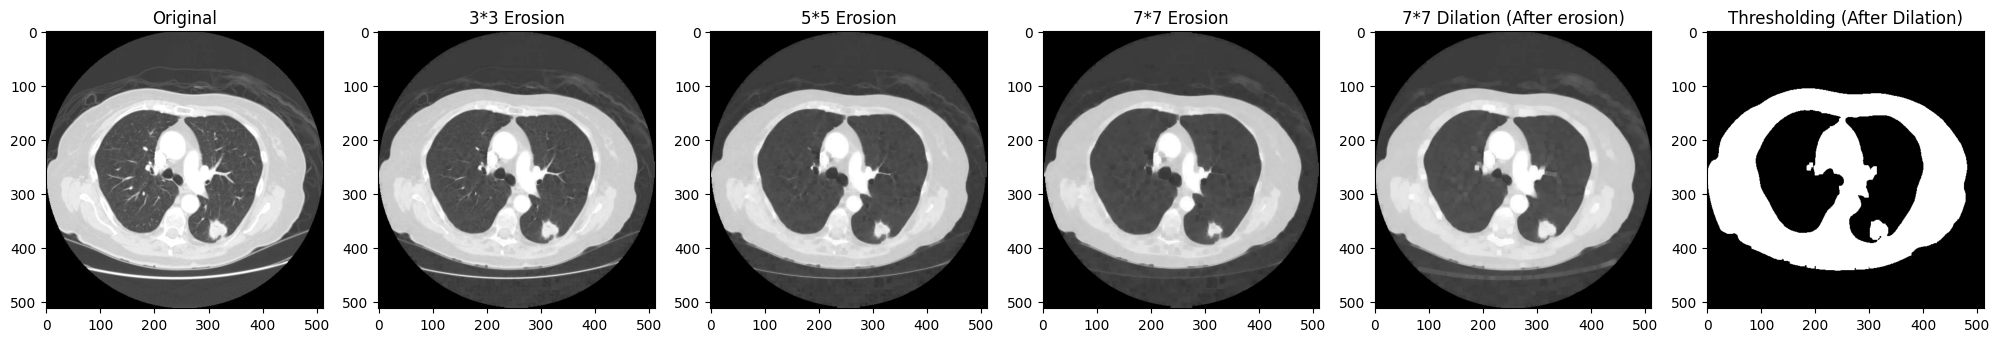

In [92]:
kernel_3_by_3 = np.ones((3, 3), np.uint8)
kernel_5_by_5 = np.ones((5, 5), np.uint8)
kernel_7_by_7 = np.ones((7, 7), np.uint8)
lung_erosion_3_by_3 = cv2.erode(lung, kernel_3_by_3, iterations=1)
lung_erosion_5_by_5 = cv2.erode(lung, kernel_5_by_5, iterations=1)
lung_erosion_7_by_7 = cv2.erode(lung, kernel_7_by_7, iterations=1)
lung_dilation_7_by_7 = cv2.dilate(lung_erosion_7_by_7, kernel_7_by_7, iterations=1)
(_, im_bw_otsu) = cv2.threshold(lung_dilation_7_by_7, 10, 255, cv2.THRESH_OTSU)


## DISPLAYING ##
_, plots = plt.subplots(nrows=1, ncols=6, figsize=(25, 15))
plots[0].set_title("Original")
plots[0].imshow(lung, cmap='gray')
plots[1].set_title("3*3 Erosion")
plots[1].imshow(lung_erosion_3_by_3, cmap='gray')
plots[2].set_title("5*5 Erosion")
plots[2].imshow(lung_erosion_5_by_5, cmap='gray')
plots[3].set_title("7*7 Erosion")
plots[3].imshow(lung_erosion_7_by_7, cmap='gray')
plots[4].set_title("7*7 Dilation (After erosion)")
plots[4].imshow(lung_dilation_7_by_7, cmap='gray')
plots[5].set_title("Thresholding (After Dilation)")
plots[5].imshow(im_bw_otsu, cmap='gray')
plt.show()